In [2]:
# Weak Tornadoes crossing the Mississippi River (Illinois section only) analysis
# Jupyter-friendly python script (use as notebook cells or run as a .py script with ipython)
# Purpose: load UMESC Land/Water pools, build a continuous Mississippi centerline for Illinois,
# filter tornado CSV for IL/IA/MO EF0-2 after 2007-02-01, compute crossings and counts, and plot results.

In [3]:
# --- Imports and configuration ---
import os
import glob
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, box
from shapely.ops import linemerge, unary_union
import numpy as np

In [4]:
# Set plotting style
plt.rcParams.update({"figure.dpi": 150})

# --- User configuration: update these paths if needed ---
BASE_DIR = "/home/njm12/ATMS_596/Land-Water" # UMESC pools root (I already used this)
TORNADO_CSV = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv" # path to tornado CSV
TARGET_CRS = "EPSG:26915" # chosen projected CRS (UTM Zone 15) for final analysis

In [7]:
# Pools of interest (you used Pools 12-26 excluding 23, plus Open River and Open River 2)
pool_dirs = [f"Pool {p}" for p in range(12, 27) if p != 23] + ["Open River", "Open River 2"]



# --- Helper: read all pool shapefiles and combine (uses your earlier approach) ---
all_gdfs = []
for pool in pool_dirs:
# pick z15 or z16 shapefile name pattern depending on pool
    if "Open River" in pool:
        pattern = os.path.join(BASE_DIR, pool, "*z16n83.shp")
        local_crs = "EPSG:26916"
    else:
        pattern = os.path.join(BASE_DIR, pool, "*z15n83.shp")
        local_crs = TARGET_CRS


    files = glob.glob(pattern)
    if not files:
        print(f"No shapefile found for {pool} (pattern {pattern})")
        continue


    for shp in files:
        print(f"Loading: {shp}")
        gdf = gpd.read_file(shp)
        # If CRS missing, set to local_crs
        if gdf.crs is None:
            gdf = gdf.set_crs(local_crs)
        # Ensure pool-specific CRS
        gdf = gdf.to_crs(local_crs)
        # Fix invalid geometries
        gdf["geometry"] = gdf["geometry"].buffer(0)
        # Save pool name
        gdf["POOL"] = pool
        # Reproject to final TARGET_CRS for concatenation
        gdf = gdf.to_crs(TARGET_CRS)
        all_gdfs.append(gdf)


if not all_gdfs:
    raise RuntimeError("No UMESC shapefiles loaded — check BASE_DIR and patterns")


umesc_all = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True), crs=TARGET_CRS)
print(f"Combined UMESC records: {len(umesc_all)}")

Loading: /home/njm12/ATMS_596/Land-Water/Pool 12/lw_2000_p12_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 13/lw_2000_p13_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 14/lw_2000_p14_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 15/lw_2000_p15_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 16/lw_2000_p16_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 17/lw_2000_p17_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 18/lw_2000_p18_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 19/lw_2000_p19_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 20/lw_2000_p20_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 21/lw_2000_p21_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 22/lw_2000_p22_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 24/lw_2000_p24_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 25/lw_2000_p25_z15n83.shp
Loading: /home/njm12/ATMS_596/Land-Water/Pool 26/lw_2000_p26_z15

In [9]:
# --- Filter to water polygons and clip to Illinois ---
# You previously used a TIGER states file — we'll download TIGER2023 and extract Illinois
state_url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(state_url)
illinois = states[states["NAME"] == "Illinois"].to_crs(TARGET_CRS).iloc[0]


# Filter water polygons — column name in UMESC appears to be 'LAND_WATER' per your earlier output
if "LAND_WATER" not in umesc_all.columns:
    # fallback: try to find a column with 'LAND' or 'WATER' in name
    candidates = [c for c in umesc_all.columns if "LAND" in c.upper() or "WATER" in c.upper()]
    print("LAND_WATER not found; candidates:", candidates)
    if candidates:
        umesc_all["LAND_WATER"] = umesc_all[candidates[0]]
    else:
        raise KeyError("Cannot find LAND/WATER column in UMESC data — inspect umesc_all.columns")


water_only = umesc_all[umesc_all["LAND_WATER"].str.contains("Water", case=False, na=False)].copy()
print(f"Water polygons before clipping: {len(water_only)}")


# Clip to Illinois extent (this reduces to water features overlapping Illinois)
water_il = gpd.clip(water_only, illinois.geometry)
print(f"Water polygons after clipping to Illinois: {len(water_il)}")

Water polygons before clipping: 5388
Water polygons after clipping to Illinois: 2876


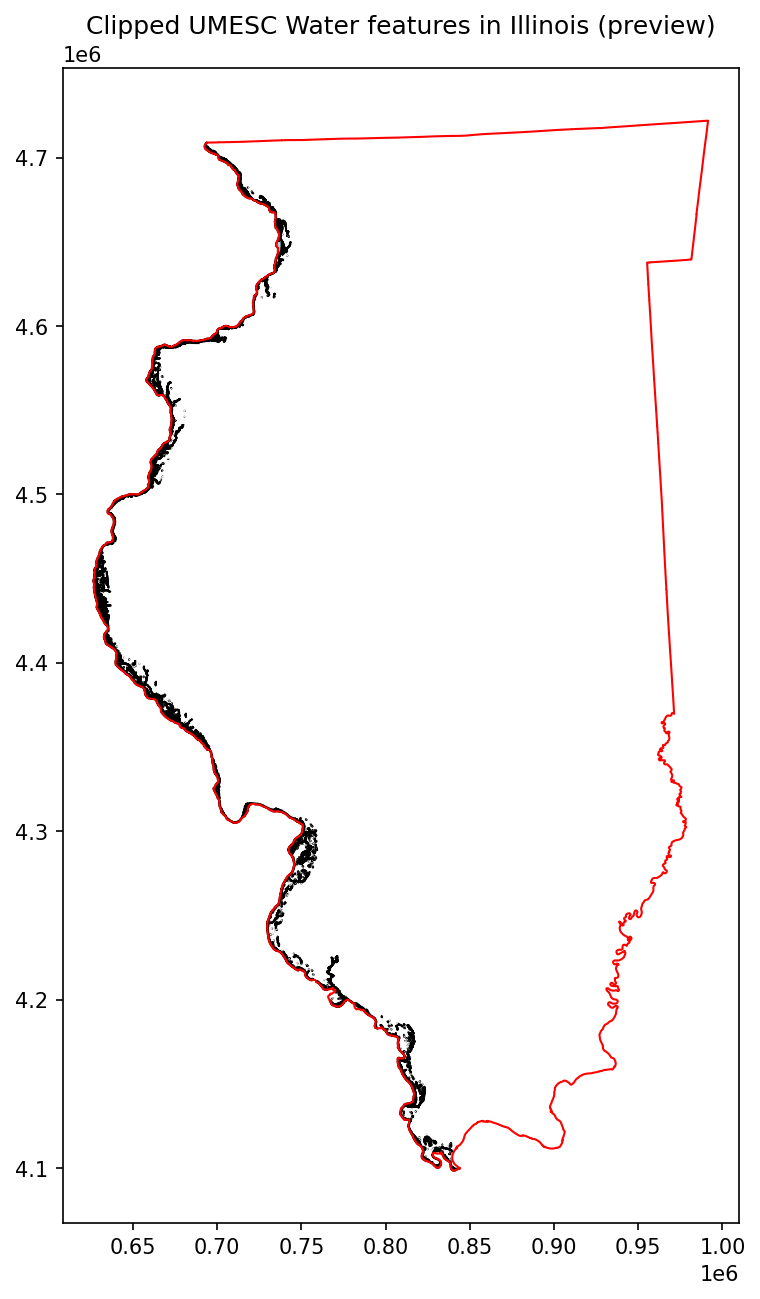

In [10]:
# Quick plot to verify (optional)
ax = water_il.plot(figsize=(6,10), color="lightblue", edgecolor="k")
# plot IL boundary
gpd.GeoSeries([illinois.geometry], crs=TARGET_CRS).boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Clipped UMESC Water features in Illinois (preview)")
plt.show()

In [12]:
# --- Attempt to derive a continuous Mississippi centerline from UMESC water polygons ---
# Approach:
# 1) select water polygons likely representing the Mississippi by spatially restricting to western border
# 2) union all such polygons, then extract the medial centerline by using polygon boundaries and
# selecting the longest line(s); finally linemerge to get continuous geometry.


# 1) Select water polygons whose centroid is near Illinois western boundary (approximate filter)
il_bounds = illinois.geometry.bounds # minx, miny, maxx, maxy
west_x = il_bounds[0]
# keep water polygons whose centroid x is within 0..20000 m east of western state edge
tol = 20000
candidate = water_il[water_il.geometry.centroid.x <= (west_x + tol)].copy()
print(f"Candidate water polygons near IL western edge: {len(candidate)}")


if len(candidate) == 0:
    raise RuntimeError("No candidate water polygons found near western Illinois. Inspect water_il.")

Candidate water polygons near IL western edge: 318


In [13]:
# 2) Extract boundaries of candidate polygons and collect LineStrings
boundaries = []
for geom in candidate.geometry:
    # exterior boundary may be MultiLineString for multipart polygons — extract all
    b = geom.boundary
    if b.geom_type == "LineString":
        boundaries.append(b)
    elif b.geom_type == "MultiLineString":
        boundaries.extend(list(b.geoms))

In [14]:
# 3) From boundaries, select the longest lines (these often track the river banks). We'll keep long ones.
lines = [ln for ln in boundaries if ln.length > 1000] # filter very small rings
print(f"Boundary lines extracted: {len(lines)}")


# Convert to GeoSeries, then linemerge the union of lines to form longer continuous lines
lines_gs = gpd.GeoSeries(lines, crs=TARGET_CRS)
merged = linemerge(unary_union(lines_gs.values))


# If merged is MultiLineString, break into components
if merged.geom_type == "MultiLineString":
    merged_lines = list(merged.geoms)
else:
    merged_lines = [merged]


# Choose the longest merged line as the best centerline approximation
centerline = max(merged_lines, key=lambda l: l.length)
print("Derived centerline length (m):", centerline.length)

Boundary lines extracted: 148
Derived centerline length (m): 68791.609416522


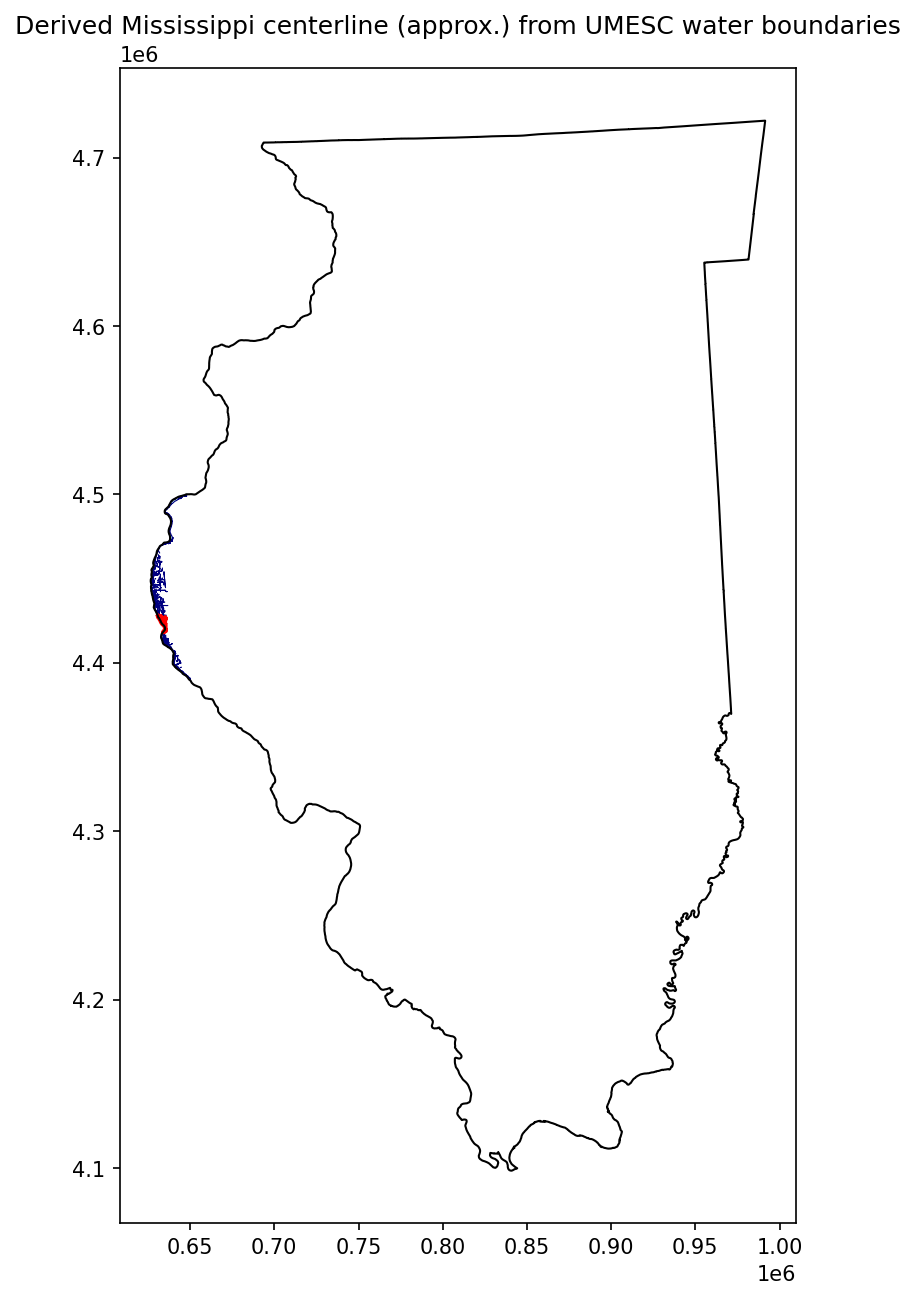

In [15]:
# Plot diagnostic: boundaries, chosen centerline
fig, ax = plt.subplots(figsize=(6,10))
candidate.plot(ax=ax, color="lightblue", edgecolor=None)
lines_gs.plot(ax=ax, linewidth=0.5, color="navy")
# plot chosen centerline
gpd.GeoSeries([centerline], crs=TARGET_CRS).plot(ax=ax, color="red", linewidth=2)
gpd.GeoSeries([illinois.geometry], crs=TARGET_CRS).boundary.plot(ax=ax, color="black", linewidth=1)
ax.set_title("Derived Mississippi centerline (approx.) from UMESC water boundaries")
plt.show()

Buffer area (sq km): 601.7216774629665


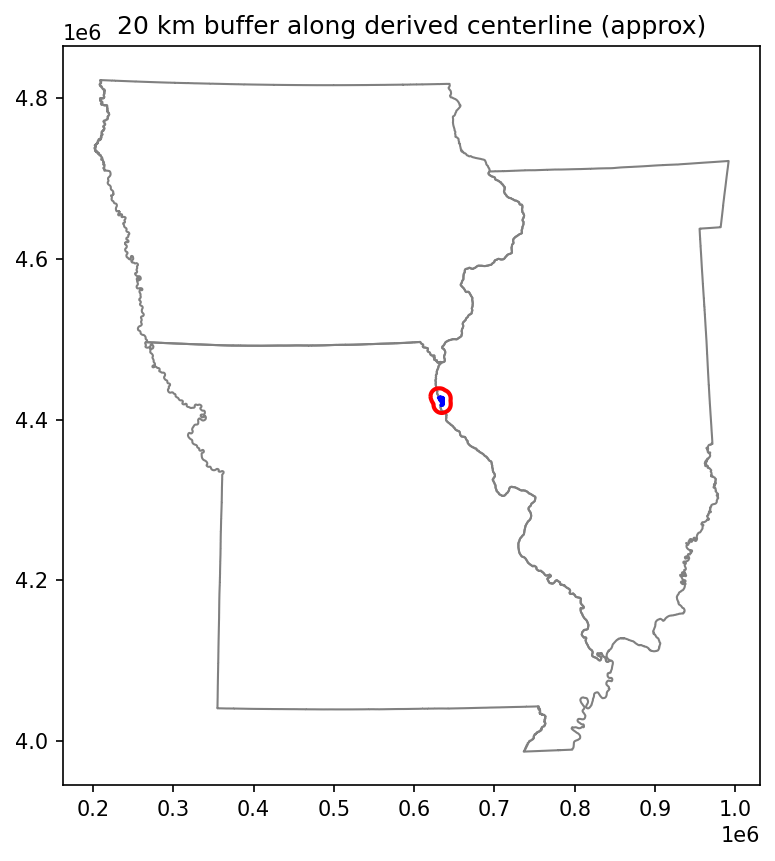

In [18]:
# --- Build a continuous 20 km wide buffer along this centerline ---
buffer_20km = centerline.buffer(10000) # 10 km each side
print("Buffer area (sq km):", buffer_20km.area / 1e6)


# Plot buffer with centerline and IL boundary
fig, ax = plt.subplots(figsize=(6,10))
midwest = states[states['NAME'].isin(['Illinois','Iowa','Missouri'])].to_crs(TARGET_CRS)
midwest.plot(ax=ax, color='none', edgecolor='gray')
# water_il.plot(ax=ax, color='lightblue') # optional
gpd.GeoSeries([buffer_20km], crs=TARGET_CRS).boundary.plot(ax=ax, color='red', linewidth=2)
# centerline
gpd.GeoSeries([centerline], crs=TARGET_CRS).plot(ax=ax, color='blue', linewidth=2)
ax.set_title('20 km buffer along derived centerline (approx)')
plt.show()